In [112]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score
import torch
from tensorboardX import SummaryWriter
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torchvision import models
from torchvision.models import alexnet
# from dataloader import dataloader, loader
from torch.utils.data import Dataset
from torchvision.transforms import Compose
from torchvision import transforms

from dataset import get_dataset
from datapreprocessing import StanfordDogsDataset
from dataloader import loader
from utils import  acculate
from model import PaperAlexNet

In [110]:
from torchvision.models import alexnet


In [100]:
NUM_EPOCHS = 30
BATCH_SIZE = 128
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
# LR =0.0001
IMAGE_DIM = 256
NUM_CLASSES = 1000  # 1000 classes for imagenet 2012 dataset

DEVICE_IDS = [0]  # GPUs to use

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [101]:
print('my location', os.getcwd())
# modify this to point to your data directory
INPUT_ROOT_DIR = './alexnet_data_in/stanford-dog-dataset'
TRAIN_IMG_DIR = os.path.join(INPUT_ROOT_DIR, 'images')
TRAIN_ANNO_DIR =  os.path.join(INPUT_ROOT_DIR, 'annotations')
TRAIN_MODEL_DIR = os.path.join(INPUT_ROOT_DIR, 'archive/alexnet.pth')

OUTPUT_ROOT_DIR =  './alexnet_data_out/stanford-dog-dataset'
LOG_DIR = os.path.join(OUTPUT_ROOT_DIR + '/tblogs' ) # tensorboard logs
CHECKPOINT_DIR = OUTPUT_ROOT_DIR + '/models'  # model checkpoints



my location c:\Users\82105\Documents\github\paper\computer_vision\classification\c_c_alexnet


In [115]:
# load model
def model_load(TEST_MODEL_DIR, alexnet):
    alexnet = alexnet(num_classes = NUM_CLASSES).to(device)
    alexnet.load_state_dict(torch.load(TRAIN_MODEL_DIR))
    alexnet.classifier[6] = nn.Linear(4096, 5)  # 5 classes
    # train in multiple GPUs
    alexnet = torch.nn.parallel.DataParallel(alexnet, device_ids = DEVICE_IDS)
    alexnet = alexnet.to(device)
    print('AlexNet created')

    optimizer = optim.SGD(
        params = alexnet.parameters(),
        lr = LR_INIT,
        momentum = MOMENTUM,
        weight_decay= LR_DECAY
    )
    
    checkpoint = torch.load(TEST_MODEL_DIR)
    alexnet.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    return alexnet, optimizer, checkpoint

In [128]:
def get_lossesdf(checkpoint):
    try:
        losses_df = checkpoint['loss_df']
    except:
        losses_df = checkpoint['losses_df']
    
    return losses_df

In [131]:

def plot(losses_df):
    
    val_loss = losses_df['val_loss']
    train_loss = losses_df['train_loss']
    val_acc = losses_df['val_acc']
    train_acc = losses_df['train_acc']
    
    plt.subplots(constrained_layout=True)
    plt.subplot(211)

    plt.plot(val_loss, color = 'red',  alpha = 0.5, label = 'val_loss')
    plt.plot(train_loss, color = 'blue', alpha = 0.5, label = 'train_loss')
    plt.title('Model Loss')
    # plt.yticks(np.arange(0,2, ))
    plt.legend()


    plt.subplot(212)
    plt.plot(val_acc, color = 'red', alpha = 0.5, label = 'val_acc')
    plt.plot(train_acc, color = 'blue', alpha = 0.5, label = 'train_acc')
    plt.title('Model Accuracy')
    # plt.yticks(np.arange(0.1,0.4,0.1))
    plt.legend()



    plt.show()

## model1

### 1. history plot

In [118]:
model_dir = 'models1'
model_num = NUM_EPOCHS


AlexNet created


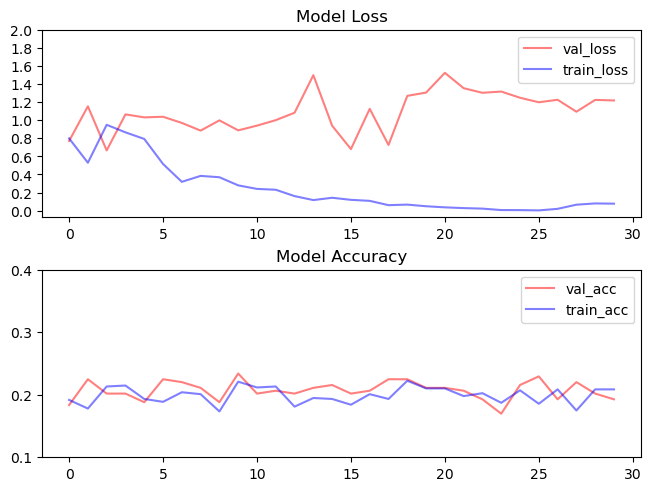

In [120]:
TEST_MODEL_DIR = os.path.join(OUTPUT_ROOT_DIR, f'{model_dir}/alexnet_states_e{model_num}.pth')
alexnet, optimizer, checkpoint = model_load(TEST_MODEL_DIR, models.alexnet)
losses_df = get_lossesdf(checkpoint)
plot(losses_df)


### 2. test : val_loss가 최저일 때 model 다시 load

In [134]:
def test_acc(losses_df):
    model_num = np.argmin(losses_df['val_loss'])
    print('min_loss', losses_df['val_loss'][model_num] )
    TEST_MODEL_DIR = os.path.join(OUTPUT_ROOT_DIR, f'{model_dir}/alexnet_states_e{model_num+1}.pth')

    alexnet, optimizer, checkpoint = model_load(TEST_MODEL_DIR, models.alexnet)

    train_X, val_X, test_X, train_y, val_y, test_y = get_dataset(TRAIN_IMG_DIR, TRAIN_ANNO_DIR)
    test_dataloader = loader(TRAIN_IMG_DIR, test_X, test_y, batch_size = BATCH_SIZE, obj = 'test')

    test_preds = []
    with torch.no_grad():
        alexnet.eval()

        for i, batch in enumerate(test_dataloader):
            img, label = batch['image'], batch['label']
            img, label = img.to(device, dtype = torch.float), label.to(device, dtype = torch.long)
            output = alexnet(img)
            
            output = output.detach().cpu().numpy()
            test_preds.extend(np.argmax(output, 1))
            
        print('test_preds', len(test_preds))
        test_acc = acculate(test_y, test_preds)

    print('Accuracy on test dataset : {:.2%}'.format(test_acc))

In [136]:
test_acc(losses_df)

min_loss 0.6442561864852905
AlexNet created
Length of annotations 120
Length of image classes 120
Number of unique annotations matches the number of classes
total number of images 20580
classes ['Maltese_dog', 'Afghan_hound', 'Scottish_deerhound', 'Pomeranian', 'Bernese_mountain_dog']
shape of dataframe: (1160, 2)
sample (3, 224, 224)
test_preds 290
Accuracy on test dataset : 21.03%


## model2

AlexNet created


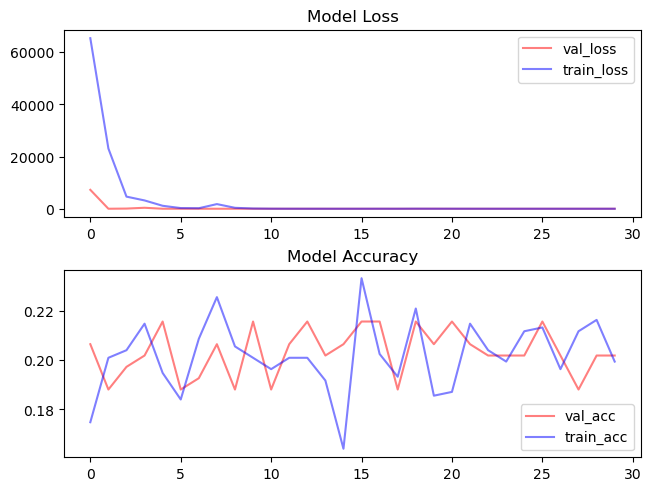

In [132]:
model_dir = 'models2'
model_num = NUM_EPOCHS
TEST_MODEL_DIR = os.path.join(OUTPUT_ROOT_DIR, f'{model_dir}/alexnet_states_e{model_num}.pth')
alexnet, optimizer, checkpoint = model_load(TEST_MODEL_DIR, models.alexnet)
losses_df = get_lossesdf(checkpoint)
plot(losses_df)

In [133]:
test_acc()

AlexNet created
Length of annotations 120
Length of image classes 120
Number of unique annotations matches the number of classes
total number of images 20580
classes ['Maltese_dog', 'Afghan_hound', 'Scottish_deerhound', 'Pomeranian', 'Bernese_mountain_dog']
shape of dataframe: (1160, 2)
sample (3, 224, 224)
test_preds 290
Accuracy on test dataset : 20.69%
